In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob

from src.auth.utils import identify
from tqdm import tqdm
import os
from pprint import pprint
from src.auth.utils import authorize

import warnings
import pandas as pd
import numpy as np
import random

from src.audio_modifications import (
    AmplitudeMultiplier,
    GaussianNoiseInserter,
    CustomNoiseInserter,
    Subsampler,
)

import librosa

/home/staszek/mgr/Biometrics-Lab-Behavioral-Based-Auth/env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/staszek/mgr/Biometrics-Lab-Behavioral-Based-Auth/env/lib/python3.8/site-packages/IPython/extensions/autoreload.py:208: UserWarning: Module 'speechbrain.pretrained' was deprecated, redirecting to 'speechbrain.inference'. Please update your script. This is a change from SpeechBrain 1.0. See: https://github.com/speechbrain/speechbrain/releases/tag/v1.0.0
  if not hasattr(module, "__file__") or module.__file__ is None:


In [ ]:
DENOISE_PARAMETER = False

# Experiment 1


In [3]:
enrolled_users = glob.glob("data/vox1/*")
enrolled_users = [user.split("/")[-1] for user in enrolled_users]
print(enrolled_users[0:3])
print("and others...")

['Peter_Jacobson', 'Chris_Lowell', 'Miranda_Hart']
and others...


In [4]:
enrolled_user_samples = glob.glob("data/vox1/*/profile/*.wav")
print(enrolled_user_samples[0:3])
print("and others...")

['data/vox1/Peter_Jacobson/profile/Peter_Jacobson_file38.wav', 'data/vox1/Peter_Jacobson/profile/Peter_Jacobson_file49.wav', 'data/vox1/Peter_Jacobson/profile/Peter_Jacobson_file50.wav']
and others...


In [5]:
def get_test_samples_for_user(user):
    test_samples = glob.glob(f"data/vox1/{user}/test_positive/*.wav")
    return test_samples

In [6]:
def get_username_from_sample_path(path):
    directories, filename = os.path.split(path)
    directories_list = directories.split(os.path.sep)
    result = directories_list + [filename]
    result = result[2]
    return result

In [7]:
positive_autorization_users_v0 = []
for user in enrolled_users[:50]:
    test_samples = get_test_samples_for_user(user)
    positive_autorization_users_v0.extend(
        list(map(lambda x: (user, x), test_samples[7:12]))
    )

negative_autorization_users_v0 = []
for idx, user in enumerate(enrolled_users[50:100]):
    test_samples = get_test_samples_for_user(user)
    negative_autorization_users_v0.extend(
        list(map(lambda x: (enrolled_users[idx], x), test_samples[7:12]))
    )
print("positive autorization users")
pprint(positive_autorization_users_v0[0:3])
print("and others...")
print("negative autorization users")
pprint(negative_autorization_users_v0[0:3])
print("and others...")

positive autorization users
[('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file44.wav'),
 ('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file19.wav'),
 ('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file3.wav')]
and others...
negative autorization users
[('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file64.wav'),
 ('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file55.wav'),
 ('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file22.wav')]
and others...


In [8]:
if os.path.exists("exp1_results.csv"):
    exp1_results = pd.read_csv("exp1_results.csv")
else:
    exp1_results = pd.DataFrame(columns=["threshold", "f1"])
    for threshold in np.arange(0.1, 1, 0.1):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            random.seed(1111)
            for name, sample in tqdm(positive_autorization_users_v0):
                identified_username = identify(
                    sample, denoise=DENOISE_PARAMETER, threshold=threshold
                )
                if name == identified_username:
                    tp += 1
                else:
                    fn += 1
            for name, sample in tqdm(negative_autorization_users_v0):
                identified_username = identify(
                    sample, denoise=DENOISE_PARAMETER, threshold=threshold
                )
                if identified_username == None:
                    tn += 1
                else:
                    fn += 1
        f1 = 2 * tp / (2 * tp + fp + fn)
        exp1_results.loc[len(exp1_results)] = (threshold, f1)

100%|██████████| 250/250 [00:01<00:00, 154.39it/s]


In [9]:
chosen_threshold = exp1_results.loc[exp1_results["f1"].idxmax()]["threshold"]
print(chosen_threshold)

0.9


In [10]:
exp1_results.to_csv("exp1_results.csv", index=False)

In [11]:
display(exp1_results)

,threshold,f1
0,0.1,0.000000
1,0.2,0.000000
2,0.3,0.053640
3,0.4,0.334165
4,0.5,0.576547
5,0.6,0.639889
6,0.7,0.661290
7,0.8,0.663102
8,0.9,0.664887


# Experiment 2


In [12]:
positive_autorization_users = []
for user in enrolled_users[:50]:
    test_samples = get_test_samples_for_user(user)
    positive_autorization_users.extend(list(map(lambda x: (user, x), test_samples[:5])))

negative_autorization_users = []
for idx, user in enumerate(enrolled_users[50:100]):
    test_samples = get_test_samples_for_user(user)
    negative_autorization_users.extend(
        list(map(lambda x: (enrolled_users[idx], x), test_samples[:5]))
    )
print("positive autorization users")
pprint(positive_autorization_users[0:3])
print("and others...")
print("negative autorization users")
pprint(negative_autorization_users[0:3])
print("and others...")

positive autorization users
[('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file55.wav'),
 ('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file26.wav'),
 ('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file13.wav')]
and others...
negative autorization users
[('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file46.wav'),
 ('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file1.wav'),
 ('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file59.wav')]
and others...


In [13]:
if os.path.exists("exp2_results.csv"):
    exp2_results = pd.read_csv("exp2_results.csv")
else:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        exp2_results = pd.DataFrame(
            columns=["sample", "user", "expected_result", "result"]
        )

        for data in tqdm(positive_autorization_users):
            user, sample = data
            result = authorize(
                sample, user, threshold=chosen_threshold, denoise=DENOISE_PARAMETER
            )
            exp2_results.loc[len(exp2_results)] = (sample, user, True, result)

        for data in tqdm(negative_autorization_users):
            user, sample = data
            result = authorize(
                sample, user, threshold=chosen_threshold, denoise=DENOISE_PARAMETER
            )
            exp2_results.loc[len(exp2_results)] = (sample, user, False, result)

100%|██████████| 250/250 [00:01<00:00, 158.06it/s]


In [14]:
exp2_results.to_csv("exp2_results.csv", index=False)

In [15]:
tp = exp2_results.loc[
    (exp2_results["expected_result"] == True) & (exp2_results["result"] == True)
].shape[0]
fp = exp2_results.loc[
    (exp2_results["expected_result"] == False) & (exp2_results["result"] == True)
].shape[0]
tn = exp2_results.loc[
    (exp2_results["expected_result"] == False) & (exp2_results["result"] == False)
].shape[0]
fn = exp2_results.loc[
    (exp2_results["expected_result"] == True) & (exp2_results["result"] == False)
].shape[0]

print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")
print()
print(f"TPR: {tp / (tp + fn)}")
print(f"FPR: {fp / (fp + tn)}")

True Positive: 250
False Positive: 51
True Negative: 199
False Negative: 0

TPR: 1.0
FPR: 0.204


# Experiment 3


In [16]:
if os.path.exists("exp3_results.csv"):
    exp3_results = pd.read_csv("exp3_results.csv")
else:
    multipliers = [25, 1, 0.04]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        exp3_results = pd.DataFrame(
            columns=["sample", "user", "multiplier", "expected_result", "result"]
        )

        random.seed(1113)

        for data in tqdm(positive_autorization_users):
            user, sample = data

            multiplier_value = random.choice(multipliers)

            def transform(x, rate):
                multiplier = AmplitudeMultiplier(multiplier_value)
                return multiplier.process(x, rate)

            result = authorize(
                sample,
                user,
                threshold=chosen_threshold,
                transform_fn=transform,
                denoise=DENOISE_PARAMETER,
            )
            exp3_results.loc[len(exp3_results)] = (
                sample,
                user,
                multiplier_value,
                True,
                result,
            )

        for data in tqdm(negative_autorization_users):
            user, sample = data

            multiplier_value = random.choice(multipliers)

            def transform(x, rate):
                multiplier = AmplitudeMultiplier(multiplier_value)
                return multiplier.process(x, rate)

            result = authorize(
                sample,
                user,
                threshold=chosen_threshold,
                transform_fn=transform,
                denoise=DENOISE_PARAMETER,
            )
            exp3_results.loc[len(exp3_results)] = (
                sample,
                user,
                multiplier_value,
                False,
                result,
            )

100%|██████████| 250/250 [00:01<00:00, 192.84it/s]


In [17]:
exp3_results.to_csv("exp3_results.csv", index=False)

In [18]:
tp = exp3_results.loc[
    (exp3_results["expected_result"] == True) & (exp3_results["result"] == True)
].shape[0]
fp = exp3_results.loc[
    (exp3_results["expected_result"] == False) & (exp3_results["result"] == True)
].shape[0]
tn = exp3_results.loc[
    (exp3_results["expected_result"] == False) & (exp3_results["result"] == False)
].shape[0]
fn = exp3_results.loc[
    (exp3_results["expected_result"] == True) & (exp3_results["result"] == False)
].shape[0]

print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")
print()
print(f"TPR: {tp / (tp + fn)}")
print(f"FPR: {fp / (fp + tn)}")

True Positive: 224
False Positive: 44
True Negative: 206
False Negative: 26

TPR: 0.896
FPR: 0.176


# Experiment 4


In [19]:
positive_autorization_users_v2 = []
for user in enrolled_users[:50]:
    test_samples = get_test_samples_for_user(user)
    positive_autorization_users_v2.extend(
        list(map(lambda x: (user, x), test_samples[5:7]))
    )

negative_autorization_users_v2 = []
for idx, user in enumerate(enrolled_users[50:100]):
    test_samples = get_test_samples_for_user(user)
    negative_autorization_users_v2.extend(
        list(map(lambda x: (enrolled_users[idx], x), test_samples[5:7]))
    )
print("positive autorization users")
pprint(positive_autorization_users_v2[0:3])
print("and others...")
print("negative autorization users")
pprint(negative_autorization_users_v2[0:3])
print("and others...")

positive autorization users
[('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file53.wav'),
 ('Peter_Jacobson',
  'data/vox1/Peter_Jacobson/test_positive/Peter_Jacobson_file8.wav'),
 ('Chris_Lowell',
  'data/vox1/Chris_Lowell/test_positive/Chris_Lowell_file48.wav')]
and others...
negative autorization users
[('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file73.wav'),
 ('Peter_Jacobson',
  'data/vox1/Olivia_Thirlby/test_positive/Olivia_Thirlby_file86.wav'),
 ('Chris_Lowell',
  'data/vox1/Michael_Mando/test_positive/Michael_Mando_file39.wav')]
and others...


In [20]:
if os.path.exists("exp4_results.csv"):
    exp4_results = pd.read_csv("exp4_results.csv")
else:
    divisors = [2, 4, 10]
    exp4_results = pd.DataFrame(
        columns=[
            "sample",
            "user",
            "expected_result",
            "result",
            "divisor",
            "original_rate",
            "new_rate",
            "original_length",
            "new_length",
        ]
    )

    for divisor in divisors:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            for data in tqdm(positive_autorization_users_v2):
                user, sample = data

                original_rate = None
                original_length = None
                new_rate = None
                new_length = None

                def transform(x, rate):
                    global original_rate, original_length, new_rate, new_length
                    subsampler = Subsampler(divisor=divisor)
                    original_rate = rate
                    original_length = librosa.get_duration(y=x, sr=rate)
                    resampled, new_sample_rate = subsampler.process(x, rate)
                    new_rate = new_sample_rate
                    new_length = librosa.get_duration(y=resampled, sr=new_sample_rate)
                    return resampled, new_sample_rate

                result = authorize(
                    sample,
                    user,
                    threshold=chosen_threshold,
                    transform_fn=transform,
                    denoise=DENOISE_PARAMETER,
                )
                exp4_results.loc[len(exp4_results)] = (
                    sample,
                    user,
                    True,
                    result,
                    divisor,
                    original_rate,
                    new_rate,
                    original_length,
                    new_length,
                )

            for data in tqdm(negative_autorization_users_v2):
                user, sample = data

                original_rate = None
                original_length = None
                new_rate = None
                new_length = None

                def transform(x, rate):
                    global original_rate, original_length, new_rate, new_length
                    subsampler = Subsampler(divisor=divisor)
                    original_rate = rate
                    original_length = librosa.get_duration(y=x, sr=rate)
                    resampled, new_sample_rate = subsampler.process(x, rate)
                    new_rate = new_sample_rate
                    new_length = librosa.get_duration(y=resampled, sr=new_sample_rate)
                    return resampled, new_sample_rate

                result = authorize(
                    sample,
                    user,
                    threshold=chosen_threshold,
                    transform_fn=transform,
                    denoise=DENOISE_PARAMETER,
                )
                exp4_results.loc[len(exp4_results)] = (
                    sample,
                    user,
                    False,
                    result,
                    divisor,
                    original_rate,
                    new_rate,
                    original_length,
                    new_length,
                )

100%|██████████| 100/100 [00:00<00:00, 156.87it/s]


<Axes: title={'center': 'Histogram of absolute difference between original and new length of audio samples'}>

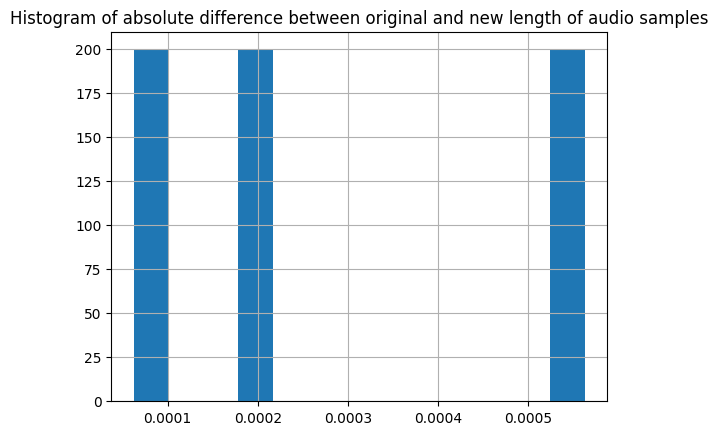

In [21]:
abs_diff = exp4_results.apply(
    lambda x: abs(x["original_length"] - x["new_length"]), axis="columns"
)

ax = abs_diff.hist(
    bins=np.linspace(np.min(abs_diff), np.max(abs_diff), np.unique(abs_diff).shape[0])
)
ax.set_title(
    "Histogram of absolute difference between original and new length of audio samples"
)
ax

In [22]:
exp4_results

,sample,user,expected_result,result,divisor,original_rate,new_rate,original_length,new_length
0,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,False,2,16000,8000.0,6.120063,6.120125
1,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,False,2,16000,8000.0,13.160063,13.160125
2,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,False,2,16000,8000.0,5.840063,5.840125
3,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,False,2,16000,8000.0,31.320062,31.320125
4,data/vox1/Miranda_Hart/test_positive/Miranda_H...,Miranda_Hart,True,False,2,16000,8000.0,4.560062,4.560125
...,...,...,...,...,...,...,...,...,...
595,data/vox1/Shay_Mitchell/test_positive/Shay_Mit...,Rob_Corddry,False,False,10,16000,1600.0,7.200062,7.200625
596,data/vox1/Stephen_Lang/test_positive/Stephen_L...,Scott_Bakula,False,False,10,16000,1600.0,19.720063,19.720625
597,data/vox1/Stephen_Lang/test_positive/Stephen_L...,Scott_Bakula,False,False,10,16000,1600.0,4.760063,4.760625
598,data/vox1/Ken_Jeong/test_positive/Ken_Jeong_fi...,Kristen_Bell,False,False,10,16000,1600.0,3.960062,3.960625


In [23]:
exp4_results.to_csv("exp4_results.csv", index=False)

In [24]:
exp4_results

,sample,user,expected_result,result,divisor,original_rate,new_rate,original_length,new_length
0,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,False,2,16000,8000.0,6.120063,6.120125
1,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,False,2,16000,8000.0,13.160063,13.160125
2,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,False,2,16000,8000.0,5.840063,5.840125
3,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,False,2,16000,8000.0,31.320062,31.320125
4,data/vox1/Miranda_Hart/test_positive/Miranda_H...,Miranda_Hart,True,False,2,16000,8000.0,4.560062,4.560125
...,...,...,...,...,...,...,...,...,...
595,data/vox1/Shay_Mitchell/test_positive/Shay_Mit...,Rob_Corddry,False,False,10,16000,1600.0,7.200062,7.200625
596,data/vox1/Stephen_Lang/test_positive/Stephen_L...,Scott_Bakula,False,False,10,16000,1600.0,19.720063,19.720625
597,data/vox1/Stephen_Lang/test_positive/Stephen_L...,Scott_Bakula,False,False,10,16000,1600.0,4.760063,4.760625
598,data/vox1/Ken_Jeong/test_positive/Ken_Jeong_fi...,Kristen_Bell,False,False,10,16000,1600.0,3.960062,3.960625


In [25]:
for divisor in exp4_results.divisor.unique():
    print("Stats for divisor:", divisor)
    filtered = exp4_results.loc[exp4_results["divisor"] == divisor]
    tp = filtered.loc[
        (filtered["expected_result"] == True) & (filtered["result"] == True)
    ].shape[0]
    fp = filtered.loc[
        (filtered["expected_result"] == False) & (filtered["result"] == True)
    ].shape[0]
    tn = filtered.loc[
        (filtered["expected_result"] == False) & (filtered["result"] == False)
    ].shape[0]
    fn = filtered.loc[
        (filtered["expected_result"] == True) & (filtered["result"] == False)
    ].shape[0]

    print(f"True Positive: {tp}")
    print(f"False Positive: {fp}")
    print(f"True Negative: {tn}")
    print(f"False Negative: {fn}")
    print()
    print(f"TPR: {tp / (tp + fn)}")
    print(f"FPR: {fp / (fp + tn)}")
    print()

Stats for divisor: 2
True Positive: 5
False Positive: 4
True Negative: 96
False Negative: 95

TPR: 0.05
FPR: 0.04

Stats for divisor: 4
True Positive: 9
False Positive: 11
True Negative: 89
False Negative: 91

TPR: 0.09
FPR: 0.11

Stats for divisor: 10
True Positive: 7
False Positive: 9
True Negative: 91
False Negative: 93

TPR: 0.07
FPR: 0.09



# Experiment 5


In [26]:
if os.path.exists("exp5_results.csv"):
    exp5_results = pd.read_csv("exp5_results.csv")
else:
    gaussian_params = [(0, 1), (0, 10), (5, 1)]

    exp5_results = pd.DataFrame(
        columns=[
            "sample",
            "user",
            "expected_result",
            "result",
            "noise_mean",
            "noise_std",
        ]
    )

    noise_factor = 5000

    for params in gaussian_params:
        mean, std = params
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")

            random.seed(1113)

            for data in tqdm(positive_autorization_users_v2):
                user, sample = data

                def transform(x, rate):
                    noise_inserter = GaussianNoiseInserter(
                        mean=mean, std=std, noise_factor=noise_factor, random_state=1113
                    )
                    return noise_inserter.process(x, rate)

                result = authorize(
                    sample,
                    user,
                    threshold=chosen_threshold,
                    transform_fn=transform,
                    denoise=DENOISE_PARAMETER,
                )
                exp5_results.loc[len(exp5_results)] = (
                    sample,
                    user,
                    True,
                    result,
                    mean,
                    std,
                )

100%|██████████| 100/100 [00:00<00:00, 136.31it/s]


In [27]:
exp5_results

,sample,user,expected_result,result,noise_mean,noise_std
0,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,False,0,1
1,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,True,0,1
2,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,False,0,1
3,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,True,0,1
4,data/vox1/Miranda_Hart/test_positive/Miranda_H...,Miranda_Hart,True,True,0,1
...,...,...,...,...,...,...
295,data/vox1/Rob_Corddry/test_positive/Rob_Corddr...,Rob_Corddry,True,False,5,1
296,data/vox1/Scott_Bakula/test_positive/Scott_Bak...,Scott_Bakula,True,True,5,1
297,data/vox1/Scott_Bakula/test_positive/Scott_Bak...,Scott_Bakula,True,False,5,1
298,data/vox1/Kristen_Bell/test_positive/Kristen_B...,Kristen_Bell,True,True,5,1


In [28]:
exp5_results.to_csv("exp5_results.csv", index=False)

In [29]:
for params in exp5_results[["noise_mean", "noise_std"]].drop_duplicates().to_numpy():
    mean, std = params
    print("Stats for mean:", mean, "std:", std)
    filtered = exp5_results.loc[
        (exp5_results["noise_mean"] == mean) & (exp5_results["noise_std"] == std)
    ]
    tp = filtered.loc[
        (filtered["expected_result"] == True) & (filtered["result"] == True)
    ].shape[0]
    fp = filtered.loc[
        (filtered["expected_result"] == False) & (filtered["result"] == True)
    ].shape[0]
    tn = filtered.loc[
        (filtered["expected_result"] == False) & (filtered["result"] == False)
    ].shape[0]
    fn = filtered.loc[
        (filtered["expected_result"] == True) & (filtered["result"] == False)
    ].shape[0]

    print(f"True Positive: {tp}")
    print(f"False Positive: {fp}")
    print(f"True Negative: {tn}")
    print(f"False Negative: {fn}")
    print()
    print(f"TPR: {tp / (tp + fn)}")
    print(f"FNR: {fn / (tp + fn)}")
    print()

Stats for mean: 0 std: 1
True Positive: 60
False Positive: 0
True Negative: 0
False Negative: 40

TPR: 0.6
FNR: 0.4

Stats for mean: 0 std: 10
True Positive: 1
False Positive: 0
True Negative: 0
False Negative: 99

TPR: 0.01
FNR: 0.99

Stats for mean: 5 std: 1
True Positive: 60
False Positive: 0
True Negative: 0
False Negative: 40

TPR: 0.6
FNR: 0.4



# Experiment 6


In [30]:
cafe, cafe_sample_rate = librosa.load("./audio/cafe.wav")


if os.path.exists("exp6_results.csv"):
    exp6_results = pd.read_csv("exp6_results.csv")
else:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        exp6_results = pd.DataFrame(
            columns=[
                "sample",
                "user",
                "expected_result",
                "result",
            ]
        )

        for data in tqdm(positive_autorization_users_v2):
            user, sample = data

            def transform(x, rate):
                wave = librosa.resample(
                    y=cafe, orig_sr=cafe_sample_rate, target_sr=rate
                )
                noise_inserter = CustomNoiseInserter(wave)
                return noise_inserter.process(x, rate)

            result = authorize(
                sample,
                user,
                threshold=chosen_threshold,
                transform_fn=transform,
                denoise=DENOISE_PARAMETER,
            )

            exp6_results.loc[len(exp6_results)] = (sample, user, True, result)

100%|██████████| 100/100 [00:01<00:00, 93.16it/s]


In [31]:
exp6_results

,sample,user,expected_result,result
0,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,True
1,data/vox1/Peter_Jacobson/test_positive/Peter_J...,Peter_Jacobson,True,True
2,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,True
3,data/vox1/Chris_Lowell/test_positive/Chris_Low...,Chris_Lowell,True,True
4,data/vox1/Miranda_Hart/test_positive/Miranda_H...,Miranda_Hart,True,True
...,...,...,...,...
95,data/vox1/Rob_Corddry/test_positive/Rob_Corddr...,Rob_Corddry,True,True
96,data/vox1/Scott_Bakula/test_positive/Scott_Bak...,Scott_Bakula,True,True
97,data/vox1/Scott_Bakula/test_positive/Scott_Bak...,Scott_Bakula,True,True
98,data/vox1/Kristen_Bell/test_positive/Kristen_B...,Kristen_Bell,True,True


In [32]:
tp = exp6_results.loc[
    (exp6_results["expected_result"] == True) & (exp6_results["result"] == True)
].shape[0]
fp = exp6_results.loc[
    (exp6_results["expected_result"] == False) & (exp6_results["result"] == True)
].shape[0]
tn = exp6_results.loc[
    (exp6_results["expected_result"] == False) & (exp6_results["result"] == False)
].shape[0]
fn = exp6_results.loc[
    (exp6_results["expected_result"] == True) & (exp6_results["result"] == False)
].shape[0]

print(f"True Positive: {tp}")
print(f"False Positive: {fp}")
print(f"True Negative: {tn}")
print(f"False Negative: {fn}")
print()
print(f"TPR: {tp / (tp + fn)}")
print(f"FNR: {fn / (tp + fn)}")

True Positive: 100
False Positive: 0
True Negative: 0
False Negative: 0

TPR: 1.0
FNR: 0.0


In [33]:
exp6_results.to_csv("exp6_results.csv", index=False)